# Association tiling / cardinality

**Author**: Melissa DeLucchi

This notebook attempts to answer a question from another notebook: "What percent of counterparts are in the same/nested healpix pixel? vs how many are in neighboring pixels?"

We can get the answer to this (and related questions) just by looking through the `_metadata` file.

In [1]:
import warnings
from typing import Dict, List

import numpy as np
import pandas as pd
import pyarrow as pa

from hipscat.catalog.partition_info import PartitionInfo
from hipscat.io import FilePointer, file_io, paths
from hipscat.io.parquet_metadata import (
    read_row_group_fragments,
    row_group_stat_single_value,
    write_parquet_metadata_for_batches,
)
from hipscat.pixel_math.healpix_pixel import HealpixPixel

metadata_path = '/data3/epyc/data3/hipscat/test_catalogs/macauff_association/_metadata'

In [2]:
%%time

pixel_frame = pd.DataFrame(
    [
        (
            row_group_stat_single_value(row_group, "Norder"),
            row_group_stat_single_value(row_group, "Npix"),
            row_group_stat_single_value(row_group, "join_Norder"),
            row_group_stat_single_value(row_group, "join_Npix"),
            row_group.num_rows,
        )
        for row_group in read_row_group_fragments(metadata_path)
    ],
    columns=["Norder","Npix","join_Norder","join_Npix","num_rows" ],
)

CPU times: user 2min 22s, sys: 3.44 s, total: 2min 25s
Wall time: 2min 25s


This might be the *least* pythonic way to do this, but I don't care. I want to know if the right pixel is the SAME as the left pixel, if one is nested inside the other, or if they're totally non-overlapping.

In [3]:
tile_type = [None] * len(pixel_frame)

for index, row in pixel_frame.iterrows():
    row_type = "huh?"
    if row["Norder"] == row["join_Norder"] and row["Npix"] == row["join_Npix"]:
        row_type = "same_pixel"
    else:
        if row["Norder"] == row["join_Norder"]:
            row_type = "non-overlapping"
        elif row["Norder"] < row["join_Norder"]:
            order_diff = row["join_Norder"] - row["Norder"]
            shifted_j = row["join_Npix"] >> 2*(row["join_Norder"] - row["Norder"])
            if shifted_j == row["Npix"]:
                row_type = "join_larger"
            else:
                row_type = "non-overlapping"
        elif row["Norder"] > row["join_Norder"]:
            order_diff = row["join_Norder"] - row["Norder"]
            shifted_p = row["Npix"] >> 2*(row["Norder"] - row["join_Norder"])
            if shifted_p == row["join_Npix"]:
                row_type = "primary_larger"
            else:
                row_type = "non-overlapping"
            
    tile_type[index] = row_type
pixel_frame["tile_type"] = tile_type

In [4]:
grouped = pixel_frame.groupby('tile_type').agg({'tile_type':'count', 'num_rows': 'sum'})
grouped["percent"] = grouped["num_rows"] / grouped["num_rows"].sum() *100
grouped

,tile_type,num_rows,percent
tile_type,,,
join_larger,2048,172667550,22.908913
non-overlapping,11746,71717,0.009515
primary_larger,1967,127014600,16.851843
same_pixel,1604,453959534,60.229728


## Punch line 1

Less than 0.01% of high quality macauff matches are occurring in non-overlapping pixels. They represent a pretty big portion of the total partition_join_info data, but very little of the object matches.

I'm curious about the non-overlapping partitions. `71717/11746` suggests that there are only a handful of counterparts identified in what would be each margin.

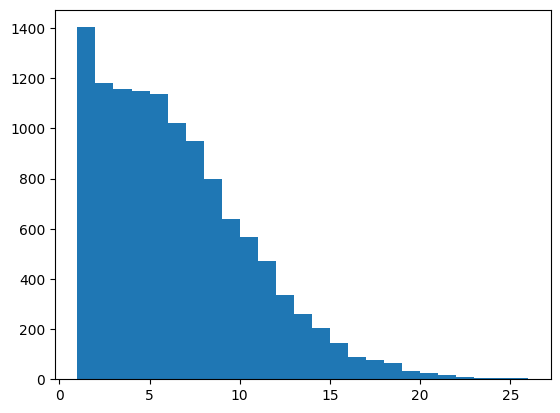

In [15]:
import matplotlib.pyplot as plt

non_overlapping = pixel_frame.query("tile_type == 'non-overlapping'")
bin_range = np.arange(non_overlapping["num_rows"].min(), non_overlapping["num_rows"].max()+1)
_ = plt.hist(non_overlapping["num_rows"], bins=bin_range)
plt.show()
